In [878]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import imghdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [879]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [880]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    #prevents overuse of gpu memory

In [881]:
data = tf.keras.utils.image_dataset_from_directory('data', shuffle = True, batch_size=16) 
#these load the data 

Found 5840 files belonging to 2 classes.


In [882]:
def count_files_per_class(dataset_directory):
    class_count = {}  # Dictionary to store the file count per class
    for entry in os.scandir(dataset_directory):
        if entry.is_dir():  # Check if entry is a directory
            class_name = entry.name  # Get the class name
            class_path = entry.path  # Get the path to the class directory
            file_count = sum(1 for _ in os.scandir(class_path) if _.is_file())  # Count the number of files in the class directory
            class_count[class_name] = file_count  # Store the file count for the class
    return class_count

# Example usage
data_directory = 'data'  

train_class_count = count_files_per_class(data_directory)

print("Train dataset:")
for class_name, count in train_class_count.items():
    print(f"Class: {class_name}, Files: {count}")

Train dataset:
Class: NORMAL, Files: 1575
Class: PNEUMONIA, Files: 4265


In [883]:
#There is a big imbalance in the training set which we will fix by determining and initializing the training weights according to each class size. 

In [884]:
#iterates between all the data so you can loop through it (used to create batches)
data_iterator = data.as_numpy_iterator()

In [885]:
batch = data_iterator.next()

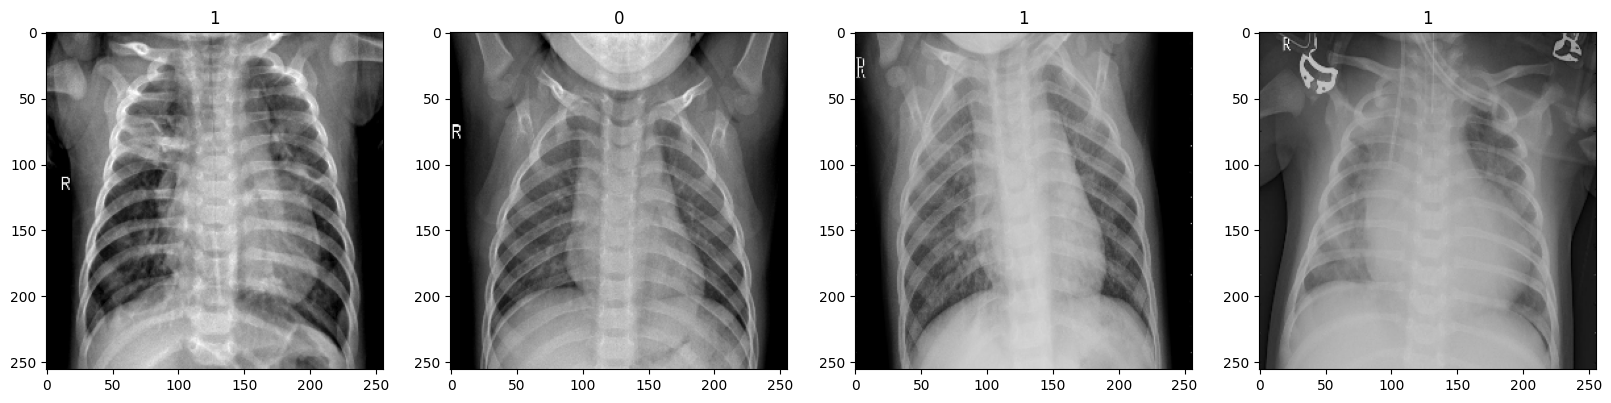

In [888]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    
#This shows four of the images in a batch along with a class   

In [889]:
data = data.map(lambda x,y: (x/255, y)) #scales the data so it's between 0 and 1 instead of 0 and 255

In [890]:
batch = data_iterator.next()

In [891]:
#these determine the portion of images which will be used for training, cross validation, and testing
train_size = int(len(data)*.7) 
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)

In [892]:
#look at the number of batches
len(data)

365

In [893]:
#make sure that it split correctly
print(train_size + val_size + test_size)

365


In [894]:
train = data.take(train_size) #takes 70% for train
val = data.skip(train_size).take(val_size) #skips train and takes 20% for val
test = data.skip(train_size+val_size).take(test_size) #skips both train and val and takes 10% for testing 

In [1]:
data.as_numpy_iterator().next()
#the values are now in between 0 and 1

In [980]:
#kernel_regularizer=regularizers.l2(0.01)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [981]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, verbose=2, mode='max') #reduce learning rate by 20% if valuation loss doesn't improve for 2 epochs
checkpoint = ModelCheckpoint(filepath='best_so_far.h5', save_best_only=True, save_weights_only=False) #save the best weights in the training
early_stop = EarlyStopping(monitor='val_loss', patience=3, mode='min') #stops training if valuation loss doesn't improve for 3 epochs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #compiles model with binary cross entropy, adam optimizer, measuring accuracy

In [982]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 127, 127, 32)      0         
                                                                 
 conv2d_81 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 dropout_46 (Dropout)        (None, 62, 62, 64)      

In [983]:
#the logs folder will be used to look at the training process step by step after it's done in order to evaluate performance
logdir='logs'

In [984]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [985]:
#these are for determining the class weights. We will initialize these to counteract the big data imbalance
COUNT_NORMAL = 1185
COUNT_PNEUMONIA = 3875
TRAIN_IMG_COUNT = COUNT_PNEUMONIA + COUNT_NORMAL

#Calculate the class weights
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

#Create the class weight dictionary
class_weight = {0: weight_for_0, 1: weight_for_1}

#Print the class weights
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 2.14
Weight for class 1: 0.65


In [986]:
#Training!
#tf.config.set_visible_devices(physical_devices[0], 'GPU')
hist = model.fit(data, epochs=20, class_weight = class_weight, validation_data=val, callbacks=[tensorboard_callback, lr_reduce, checkpoint, early_stop])

Epoch 1/20
365/365 [==============================] - 17s 45ms/step - loss: 0.4286 - accuracy: 0.8151 - val_loss: 0.3235 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 2/20
365/365 [==============================] - 16s 44ms/step - loss: 0.2256 - accuracy: 0.9065 - val_loss: 0.1687 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 3/20
365/365 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9279
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
365/365 [==============================] - 16s 45ms/step - loss: 0.1801 - accuracy: 0.9279 - val_loss: 0.1339 - val_accuracy: 0.9519 - lr: 0.0010
Epoch 4/20
365/365 [==============================] - 16s 44ms/step - loss: 0.1492 - accuracy: 0.9414 - val_loss: 0.1020 - val_accuracy: 0.9654 - lr: 8.0000e-04
Epoch 5/20
363/365 [============================>.] - ETA: 0s - loss: 0.1314 - accuracy: 0.9514
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
365/365 [===========================

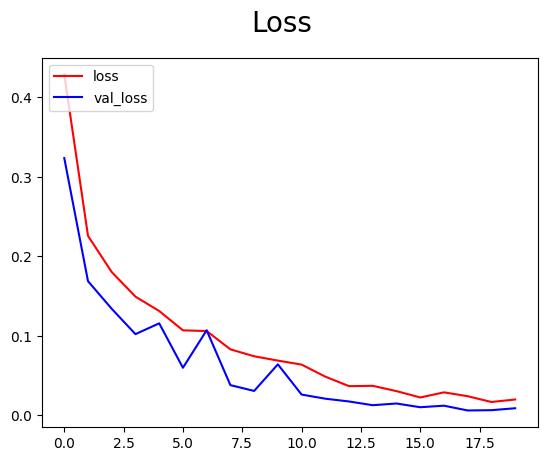

In [988]:
#Performance evaluation. See why we put the training call as hist!
#This here is loss and cross validation loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['val_loss'], color='blue', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

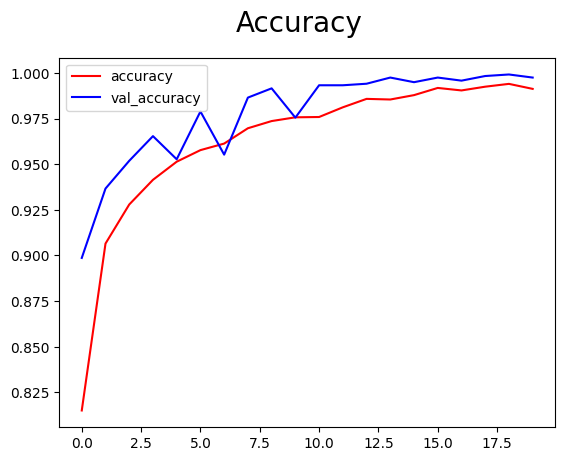

In [989]:
#This here is accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='red', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='blue', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [990]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [991]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()


In [992]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 17ms/step


In [993]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:0.9976019263267517, Accuracy:0.9982638955116272


In [1010]:
#testing on some images
img = cv2.imread('test/PNEUMONIA/8.jpeg')
#plt.imshow(img)
#plt.show()
resize = tf.image.resize(img, (256,256))
#plt.imshow(resize.numpy().astype(int))
#plt.show()
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat
if yhat > 0.5:
    print("This person has pneumonia")
else:
    print("This person does not have pneumonia")

1/1 [==============================] - 0s 18ms/step
This person has pneumonia


In [1011]:
model.save(os.path.join('models','THE_ONE.h5'))